In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [9]:
# Define color scheme for architecture types
color_scheme = {
    "n_stores_per_store_net": "#2ca02c",  # Green
    "n_stores_shared_net": "#ff7f0e",  # Orange
    "vanilla_n_stores": "#d62728"  # Red
}

testset_name = "finals_weight_sharing"

# Define architectures with their path patterns
architectures = {
    "vanilla_n_stores": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_n_stores',
    "n_stores_shared_net": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/n_stores_shared_net',
    "n_stores_per_store_net": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/n_stores_per_store_net'
}

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

# Define number of stores and sample sizes
n_stores = [3, 5, 10, 20, 30, 50]
sample_sizes = [8192, 1024, 128]
optimal_loss = 6.53  # Optimal loss value

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

results_interpretor = rri.RayResultsinterpreter()

dfs = []

# Create dataframes for each architecture, store size and sample size
for arch_name, path_fn in architectures.items():
    path = path_fn(None)
    df = results_interpretor.make_table({1: path},
        {'train_dev_sample_and_batch_size': sample_sizes, 'n_stores': n_stores},
        default_condition_setter, custom_data_filler,
        sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

    if not df.empty:
        df.insert(2, 'Architecture Class', arch_name)
        df.insert(1, 'hyperparam_name', arch_name)
        df['# of stores'] = df['n_stores']
        # n_stores and # of stores columns will be set by make_table if present in the data
        dfs.append(df)
df = pd.concat(dfs)

In [11]:
import numpy as np

test_loss_column = 'Test Loss'
test_loss_filename = 'test_loss.txt'

test_losses = []
for _, row in df.iterrows():
    test_loss_path = str(row['path']) + "/" + test_loss_filename
    try:
        with open(test_loss_path, 'r') as f:
            value = float(f.read().strip())
    except Exception:
        value = np.nan
    test_losses.append(value)

df[test_loss_column] = test_losses

    # of stores  train_dev_sample_and_batch_size      Architecture Class  n_stores  Train Loss  Dev Loss  Test Loss                                                                                                                                                                                                                                                          path  Optimality Gap %
0             3                              128        vanilla_n_stores         3    6.498646  6.641177   6.590198        /user/ml4723/Prj/NIC/ray_results/finals_weight_sharing/vanilla_n_stores/run_2025-04-28_11-32-15/run_f6668_00431_431_config=n_stores_lost_demand_optimal,different_for_each_sample=True,early_stop_check_epochs=10,learning_rate=0._2025-04-29_02-25-21          0.921865
0             3                              128     n_stores_shared_net         3    6.533234  6.607551   6.543321     /user/ml4723/Prj/NIC/ray_results/finals_weight_sharing/n_stores_shared_net/run_2025-05-10_12-21-51/run_e

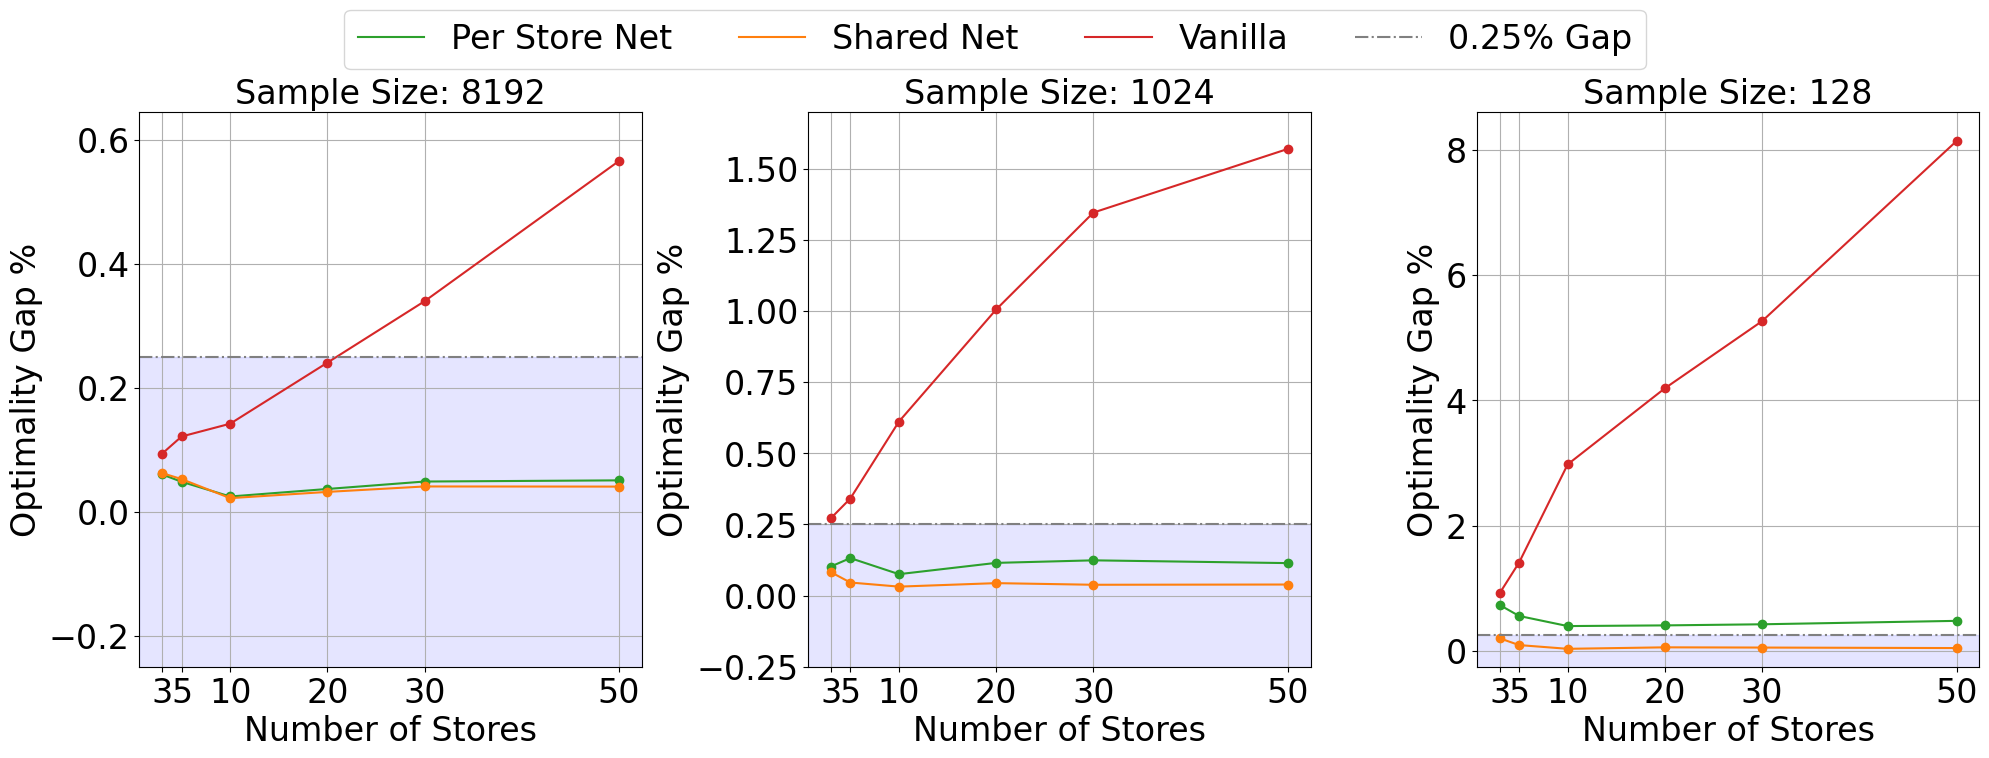

In [12]:
# Calculate optimality gap
df['Optimality Gap %'] = ((df['Test Loss'] - optimal_loss) / optimal_loss) * 100
df.insert(df.columns.get_loc(df.columns[-1]), 'Optimality Gap %', df.pop('Optimality Gap %'))
df.sort_values(by=['# of stores', 'train_dev_sample_and_batch_size'], inplace=True)

df_to_print = df.copy()
df_to_analyze = df_to_print.copy()
columns_to_drop = ['Learning Rate', 'include_context_for_warehouse_input', '# of runs', 'hyperparam_name', 'store_orders_for_warehouse']
df_to_print.drop(columns=[col for col in columns_to_drop if col in df_to_print.columns], inplace=True)
print(df_to_print.to_string())

# Create plot grid for different sample sizes
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

for idx, sample_size in enumerate(sample_sizes):
    df_sample = df[df['train_dev_sample_and_batch_size'] == sample_size]
    pivot_df = df_sample.groupby(['# of stores', 'Architecture Class'])['Optimality Gap %'].min().unstack()
    
    ax = axes[idx]
    for column in pivot_df.columns:
        ax.plot(pivot_df.index.to_numpy(), pivot_df[column].to_numpy(),
                marker='o',
                label=column,
                color=color_scheme[column],
                linestyle='-')  # All architectures use the same solid line style
    
    # Add 0.25% optimality gap reference line
    ax.axhline(y=0.25, color='gray', linestyle='-.', alpha=1.0, label='0.25% Gap')
    ax.axhspan(-1, 0.25, color='blue', alpha=0.1)
    
    font_size = 24
    ax.set_xlabel('Number of Stores', fontsize=font_size)
    # Always add y-label to all subplots
    ax.set_ylabel('Optimality Gap %', fontsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)
    ax.set_title(f'Sample Size: {sample_size}', fontsize=font_size)
    ax.grid(True)
    ax.set_xticks(pivot_df.index)
    ax.tick_params(axis='x', labelsize=font_size)  # Set x-axis tick font size
    ax.set_ylim(bottom=-0.25)  # Set y-axis limits

# Create a custom legend for the entire figure
custom_lines = [
    plt.Line2D([0], [0], color=color_scheme["n_stores_per_store_net"], linestyle='-', label='Per Store Net'),
    plt.Line2D([0], [0], color=color_scheme["n_stores_shared_net"], linestyle='-', label='Shared Net'),
    plt.Line2D([0], [0], color=color_scheme["vanilla_n_stores"], linestyle='-', label='Vanilla'),
    plt.Line2D([0], [0], color='gray', linestyle='-.', label='0.25% Gap')
]
fig.legend(handles=custom_lines, loc='upper center', fontsize=font_size, ncol=4, bbox_to_anchor=(0.5, 1.1))

plt.tight_layout()
plt.show()

In [3]:
mode = "test"
setting_name = 'n_stores_lost_demand_optimal_1000'

models = []
for _, row in df.iterrows():
    models.append(str(row['path']) + '/model.pt')

gpus = [0, 1, 4, 5, 7]

def run_main_run(model_path, gpu_idx):
    try:
        # Extract hyperparam name from model path
        hyperparam_name = model_path.split('/')[7]
        print(f"Running main_run.py for path {model_path}")
        cmd = [
            "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
            "main_run.py",
            mode, # test or test_on_dev
            setting_name,
            hyperparam_name,
            str(model_path),
            str(gpus[gpu_idx])
        ]
        env = {
            **os.environ,
            "MKL_THREADING_LAYER": "GNU",
            "MKL_SERVICE_FORCE_INTEL": "1"
        }
        subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
    except subprocess.CalledProcessError as e:
        print(f"Error running main_run.py for path {model_path}: {e}")
        print(f"Error output: {e.stderr}")
    except Exception as e:
        print(f"Unexpected error running main_run.py for path {model_path}: {e}")

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    gpu_idx = 0
    for path in models:
        while len(futures) >= 9*len(gpus):
            done, not_done = concurrent.futures.wait(
                futures, 
                return_when=concurrent.futures.FIRST_COMPLETED
            )
            futures = list(not_done)
        futures.append(executor.submit(run_main_run, path, gpu_idx))
        gpu_idx = (gpu_idx + 1) % len(gpus)
    concurrent.futures.wait(futures)


Running main_run.py for path /user/ml4723/Prj/NIC/ray_results/finals_weight_sharing/vanilla_n_stores/run_2025-04-28_11-32-15/run_f6668_00431_431_config=n_stores_lost_demand_optimal,different_for_each_sample=True,early_stop_check_epochs=10,learning_rate=0._2025-04-29_02-25-21/model.pt
Running main_run.py for path /user/ml4723/Prj/NIC/ray_results/finals_weight_sharing/vanilla_n_stores/run_2025-04-28_11-32-15/run_f6668_00267_267_config=n_stores_lost_demand_optimal,different_for_each_sample=True,early_stop_check_epochs=10,learning_rate=0._2025-04-28_16-06-51/model.pt
Running main_run.py for path /user/ml4723/Prj/NIC/ray_results/finals_weight_sharing/vanilla_n_stores/run_2025-04-28_11-32-15/run_f6668_00107_107_config=n_stores_lost_demand_optimal,different_for_each_sample=True,early_stop_check_epochs=10,learning_rate=0._2025-04-28_11-32-18/model.pt
Running main_run.py for path /user/ml4723/Prj/NIC/ray_results/finals_weight_sharing/vanilla_n_stores/run_2025-04-28_11-32-15/run_f6668_00420_420_

In [14]:
columns_to_drop = ['Architecture Class', 'Learning Rate', '# of runs', 'path']
df_print = df.drop(columns=columns_to_drop)
print(df_print.to_string())

    # of stores         hyperparam_name  train_dev_sample_and_batch_size  n_stores  Train Loss  Dev Loss  Test Loss  Optimality Gap %
0             3        vanilla_n_stores                              128         3    6.498646  6.641177   6.590198          0.921865
0             3     n_stores_shared_net                              128         3    6.533234  6.607551   6.543321          0.203999
0             3  n_stores_per_store_net                              128         3    6.542151  6.614840   6.578056          0.735930
6             3        vanilla_n_stores                             1024         3    6.505027  6.578584   6.547737          0.271620
6             3     n_stores_shared_net                             1024         3    6.511566  6.566057   6.535365          0.082165
6             3  n_stores_per_store_net                             1024         3    6.494824  6.568414   6.536664          0.102056
12            3        vanilla_n_stores                       